# Replication Note

To correctly run this notebook the latest working version of the vflow package is needed. To update rule-env, run `rm -r ~/rule-env/lib/python3.8/site-packages/vflow` to first remove previous installation 
```
# in rule-env environment
cd [ROOT storing rule-vetting]
git clone https://github.com/Yu-Group/veridical-flow.git
cd veridical-flow
python setup.py develop
```
* Usually the above solution would be sufficient to solve the issue but jupyter notebook can save local packages in a .local  folder so you would need to remove it there as well and manually copy the packages from the vflow directory.....
* Debug case 1:
    * in jupyter notebook `cannot import name 'build_vset' from 'vflow' (~/.local/lib/python3.8/site-packages/vflow/__init__.py)`
    * solution run this in a jupyter notebook cell
```
!rm -r ~/.local/lib/python3.8/site-packages/vflow/*
!cp -av [veridical-flow]/vflow ~/.local/lib/python3.8/site-packages/
```

* To use new version of vflow more efficiently, we override the method for `Dataset.get_data` to include multiple output

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.interpolate import interp1d

import imodels
from imodels.experimental import stablelinear
from rulevetting.api import validation
from rulevetting.projects.csi_pecarn.dataset import Dataset
from sklearn.metrics import classification_report, confusion_matrix

# Stability Veridical Flow
from vflow import build_vset, perturbation_stats, init_args, Vset, dict_to_df
from vflow.pipeline import build_graph
import vflow, rulevetting
import sklearn, pickle
from functools import partial

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

def drop_df_meta_keys(df):
    return df.drop(columns=[c for c in df.columns if c in Dataset().get_meta_keys()])

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x.values)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def baseline_cdr_predict(X, use_2 = False):
    num_conditions = (X['AlteredMentalStatus2'] + 
                      X['FocalNeuroFindings2'] + 
                      X['PainNeck2'] +
                      X['Torticollis2'] + 
                      X['subinj_TorsoTrunk2'] + 
                      X['Predisposed'] + 
                      X['HighriskDiving'] + 
                      X['HighriskMVC'])
    preds = (num_conditions > 0).astype(int).values
    return preds

def simple_report(y_true, y_pred, verbose=True):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    if verbose:
        print(classification_report(y_true, y_pred))
        print("Specificity: ", specificity)
        print("Sensitivity: ", sensitivity)
    return sensitivity, specificity

def spec_at_sensLevel(y, y_pred_proba, sens_level=0.98, to_binary=True):
    if to_binary:
        all_stats, _ = validation.all_stats_curve(y, y_pred_proba[:, 1])
    else:
        all_stats, _ = validation.all_stats_curve(y, y_pred_proba[:, 1])
    sens, spec = all_stats['sens'], all_stats['spec']
    if np.max(sens) < sens_level:
        sens = np.concatenate((sens, [1.0]))
        spec = np.concatenate((spec, [0.0]))
    specAtLevel = interp1d(sens, spec, fill_value='extrapolate')([sens_level])
    return specAtLevel.item()


def rel_spec_to_baseline(X, y, y_pred_proba):
    y_pred_base = baseline_cdr_predict(X)
    sens_base, spec_base = simple_report(y, y_pred_base, verbose=False)
    spec_model_at_base = spec_at_sensLevel(y, y_pred_proba, sens_level=sens_base)
    return spec_model_at_base / spec_base


# Problem: to process function require: Vset(modules=[func])
def vfunc_drop_meta_train_test(dfs):
    df_train, df_tune, df_test = dfs
    X_train = drop_df_meta_keys(df_train.drop(columns=[outcome_def]))
    y_train = df_train[outcome_def].values
    X_tune = drop_df_meta_keys(df_tune.drop(columns=[outcome_def]))
    y_tune = df_tune[outcome_def].values
    X_test = drop_df_meta_keys(df_test.drop(columns=[outcome_def]))
    y_test = df_test[outcome_def].values
    return (pd.concat([X_train, X_tune]), X_test, 
            np.concatenate([y_train, y_tune]), y_test)

def vfunc_drop_meta_test(dfs):
    df_train, df_tune, df_test = dfs
    X_test = drop_df_meta_keys(df_test.drop(columns=[outcome_def]))
    y_test = df_test[outcome_def].values
    return X_test, y_test

def vfunc_resamp_from_dfs(dfs):
    df_train, df_tune, df_test = dfs
    X_train = drop_df_meta_keys(df_train.drop(columns=[outcome_def]))
    y_train = df_train[outcome_def].values
    X_tune = drop_df_meta_keys(df_tune.drop(columns=[outcome_def]))
    y_tune = df_tune[outcome_def].values
    X_test = drop_df_meta_keys(df_test.drop(columns=[outcome_def]))
    y_test = df_test[outcome_def].values
    X_trains = pd.concat([X_train, X_tune])
    y_trains = np.concatenate([y_train, y_tune])
    return sklearn.utils.resample(X_trains, y_trains)

STABILITY_PATH = oj(rulevetting.DATA_PATH, dset.get_dataset_id(), 'stability')
PLOT_PATH = oj(rulevetting.DATA_PATH, dset.get_dataset_id(), 'plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Judgement Call Perturbation Check

In [14]:
dset = Dataset()
dfs = dset.get_data(run_perturbations=True) 

kwargs {'clean_data': {'include_intervention': True}, 'preprocess_data': {'unclear_feat_default': 0, 'only_site_data': 2, 'augmented_features': True, 'use_control_type': 'all'}, 'extract_features': {'drop_negative_columns': False}}


In [15]:
N_REPS = 100
if not os.path.exists(STABILITY_PATH):
    os.makedirs(STABILITY_PATH)

spec_metrics_file = os.path.join(STABILITY_PATH, f'jcall_stability_{N_REPS}.p')

if os.path.exists(spec_metrics_file):
    with open(spec_metrics_file, 'rb') as spec_io:
        spec_metrics = pickle.load(spec_io)
else:
    drop_meta_train_tests = Vset(name='drop_meta', modules=[vfunc_drop_meta_train_test])
    X_trains, X_tests, y_trains, y_tests = drop_meta_train_tests(dfs, n_out=4, 
                                                               keys=['X_trains', 'X_tests', 'y_trains', 'y_tests'])
    bfuncs = [partial(sklearn.utils.resample, random_state=i) for i in range(N_REPS)]
    boot_set = Vset(name="boot", modules=bfuncs, lazy=True, output_matching=True)
    # build_vset('boot', sklearn.utils.resample, reps=N_REPS, lazy=True, output_matching=True)
    # reps=N_REPS gives identical results
    X_trains, y_trains = boot_set(X_trains, y_trains)

    # drop_meta_tests = Vset(name='drop_meta', modules=[vfunc_drop_meta_test], output_matching=True)
    # X_tests, y_tests = drop_meta_tests(dfs, n_out=2, keys=['X_tests', 'y_tests'])


    # bfuncs = [vfunc_resamp_from_dfs for _ in range(2)]
    # boot_set = Vset(name="boot", modules=bfuncs, output_matching=True)
    # X_trains, y_trains = boot_set(dfs, n_out=2, keys=['X_trains', 'y_trains'])

    best_model = imodels.RuleFitClassifier(max_rules=13, n_estimators=50, cv=False, random_state=0, include_linear=True)
    #best_model = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 5})

    modeling_set = Vset(name="modeling",
                        modules=[best_model],
                        module_keys=['RuleFitBest'], output_matching=True) # , 'boostedrules', 'saps'
    # models = {'DT': DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})}
    # modeling_set = Vset(name="modeling", modules=models)
    modeling_set.fit(X_trains, y_trains)
    pred_proba_tests = modeling_set.predict_proba(X_tests)
    spec_metrics_set = Vset(name='spec_metrics',
                              modules=[partial(spec_at_sensLevel, sens_level=0.96),
                                       partial(spec_at_sensLevel, sens_level=0.98)],
                              module_keys=["SpecAtSens96", "SpecAtSens98"])
    spec_metrics = spec_metrics_set.evaluate(y_tests, pred_proba_tests)
    with open(spec_metrics_file, 'wb') as spec_io:
        pickle.dump(spec_metrics, spec_io)
metric_df = dict_to_df(spec_metrics)
metric_df['preprocess_data'] = metric_df['preprocess_data'].apply(lambda v: v[:3])
metric_df['judgement_call'] = (metric_df['clean_data'] 
                               + metric_df['preprocess_data']).apply(lambda vs: '\n'.join(vs))

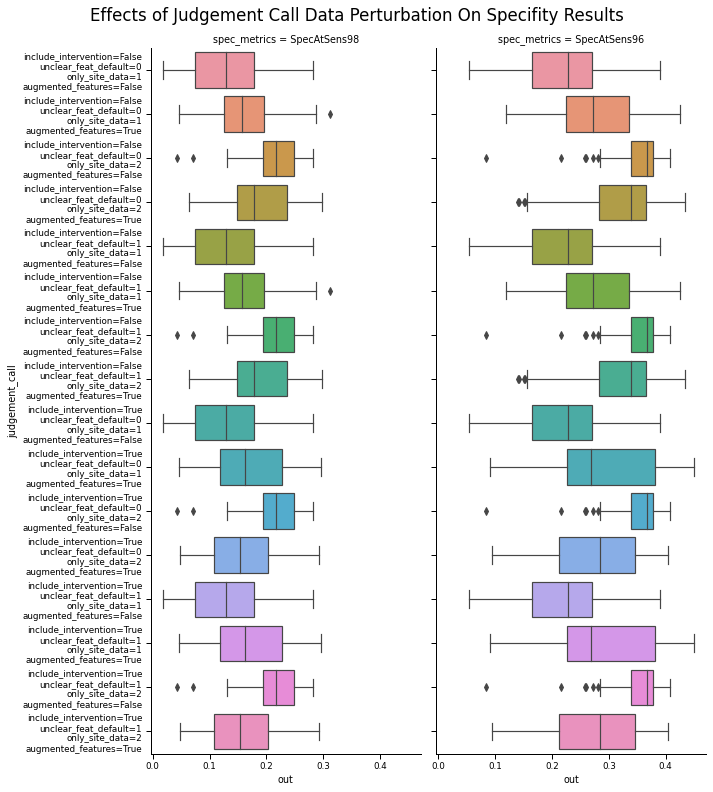

In [16]:
PLOT_PATH = oj(rulevetting.DATA_PATH, dset.get_dataset_id(), 'plots')
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
sns.set_context('paper')
plot_df = pd.DataFrame(metric_df.sort_values('judgement_call')[['judgement_call', 'spec_metrics', 'out']].values, 
                              columns=['judgement_call', 'spec_metrics', 'out'])
g = sns.catplot(x='out', y='judgement_call', col='spec_metrics', kind="box", 
                data=plot_df)
sns.despine()
g.fig.set_size_inches(10,12)
g.fig.suptitle('Effects of Judgement Call Data Perturbation On Specifity Results', size='xx-large')
g.savefig(oj(PLOT_PATH, f'jcall_perturbation_{N_REPS}.png'))

In [34]:
jcall_summary = perturbation_stats(metric_df, 'judgement_call', 'spec_metrics')
jcall_summary[[f'Arg{i}' for i in range(4)]] = jcall_summary['judgement_call'].str.split('\n', expand=True)
jcall_summary.sort_values('mean', ascending=False).iloc[:, 1:]

,spec_metrics,count,mean,std,Arg0,Arg1,Arg2,Arg3
4,SpecAtSens96,100,0.352157,0.043920,include_intervention=False,unclear_feat_default=0,only_site_data=2,augmented_features=False
28,SpecAtSens96,100,0.352157,0.043920,include_intervention=True,unclear_feat_default=1,only_site_data=2,augmented_features=False
20,SpecAtSens96,100,0.352157,0.043920,include_intervention=True,unclear_feat_default=0,only_site_data=2,augmented_features=False
12,SpecAtSens96,100,0.352157,0.043920,include_intervention=False,unclear_feat_default=1,only_site_data=2,augmented_features=False
14,SpecAtSens96,100,0.317699,0.065994,include_intervention=False,unclear_feat_default=1,only_site_data=2,augmented_features=True
6,SpecAtSens96,100,0.317699,0.065994,include_intervention=False,unclear_feat_default=0,only_site_data=2,augmented_features=True
26,SpecAtSens96,100,0.287877,0.086734,include_intervention=True,unclear_feat_default=1,only_site_data=1,augmented_features=True
18,SpecAtSens96,100,0.287877,0.086734,include_intervention=True,unclear_feat_default=0,only_site_data=1,augmented_features=True
2,SpecAtSens96,100,0.274986,0.073681,include_intervention=False,unclear_feat_default=0,only_site_data=1,augmented_features=True
10,SpecAtSens96,100,0.274986,0.073681,include_intervention=False,unclear_feat_default=1,only_site_data=1,augmented_features=True


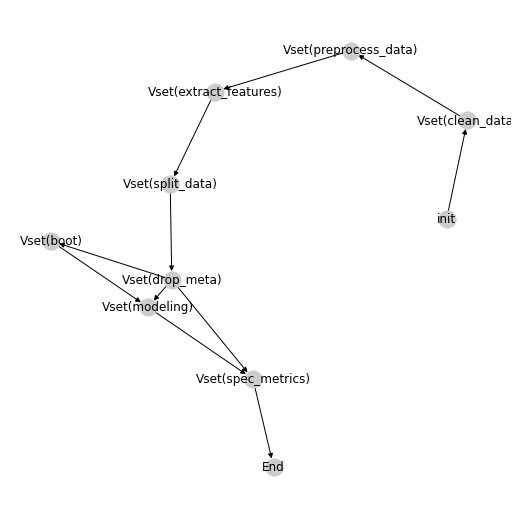

In [37]:
plt.figure(figsize=(7, 7))
sns.set_context('paper')
build_graph(spec_metrics)

## 2. Basic Stability Check of Best Model (RuleFit) Multiple Metrics

In [2]:
dset = Dataset()
df_train, df_tune, df_test = dset.get_data()
X_train = drop_df_meta_keys(df_train.drop(columns=[outcome_def]))
y_train = df_train[outcome_def].values
X_tune = drop_df_meta_keys(df_tune.drop(columns=[outcome_def]))
y_tune = df_tune[outcome_def].values
X_test = drop_df_meta_keys(df_test.drop(columns=[outcome_def]))
y_test = df_test[outcome_def].values
processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats

kwargs {'clean_data': {'include_intervention': True}, 'preprocess_data': {'unclear_feat_default': 0, 'only_site_data': 2, 'augmented_features': True, 'use_control_type': 'all'}, 'extract_features': {'drop_negative_columns': False}}


### Solution 2 refer to vflow notebook and learn from example
* Challenge: `build_vset` behavior inconsistent between user installed version and actual version
* Solutions:
    * 2.1: diagnose build_Vset to identify how vfunc
    * 2.2: circumvent this solution and write a cache based Vset function separately.

In [17]:
N_REPS = 100
if not os.path.exists(STABILITY_PATH):
    os.makedirs(STABILITY_PATH)

stab_metrics_file = os.path.join(STABILITY_PATH, f'model_stability_{N_REPS}.p')
LOAD_output = True
if os.path.exists(stab_metrics_file) and LOAD_output:
    with open(stab_metrics_file, 'rb') as stab_io:
        stab_metrics = pickle.load(stab_io)
else:
    X_train, X_test, y_train, y_test = init_args(
        (pd.concat((X_train, X_tune)), X_test, np.concatenate((y_train, y_tune)), y_test),
        names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
    )

    # bootstrap data     
    bfuncs = [partial(sklearn.utils.resample, random_state=i) for i in range(N_REPS)]
    boot_set = Vset(name="boot", modules=bfuncs, lazy=True, output_matching=True)
    # build_vset('boot', sklearn.utils.resample, reps=N_REPS, lazy=True, output_matching=True)
    # reps=N_REPS gives identical results
    X_trains, y_trains = boot_set(X_train, y_train)

    # fit models
    # TODO: Change the model opetions here to include more models
    best_model = imodels.RuleFitClassifier(max_rules=13, n_estimators=50, cv=False, random_state=0, include_linear=True)
    models = [best_model] # boost, saps
    modeling_set = Vset(name="modeling",
                        modules=models,
                        module_keys=["RuleFitBest"])

    # models = {'DT': DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})}
    # modeling_set = Vset(name="modeling", modules=models)
    modeling_set.fit(X_trains, y_trains)
    pred_proba_test = modeling_set.predict_proba(X_test)

    baseline_set = Vset(name="baseline",
                           modules=[],
                           output_matching=True)


    # get metrics
    stab_metric_set = Vset(name='stab_metrics',
                           modules=[partial(rel_spec_to_baseline),
                                    partial(vfunc_metric_wrapper, metric_func=spec_at_sensLevel, sens_level=0.96),
                                    partial(vfunc_metric_wrapper, metric_func=spec_at_sensLevel, sens_level=0.98)],
                           module_keys=["relSpecToBase", "SpecAtSens96", "SpecAtSens98"])
    stab_metrics = stab_metric_set.evaluate(X_test, y_test, pred_proba_test)
    stab_output_best = dict_to_df(stab_metrics)
    

In [12]:
def vfunc_metric_wrapper(X, y, y_proba, metric_func=spec_at_sensLevel, **kwargs):
    return metric_func(y, y_proba, **kwargs)

def stability_pipeline_best_model(X_train, X_tune, X_test, y_train, y_tune, y_test):
    N_REPS = 100
    if not os.path.exists(STABILITY_PATH):
        os.makedirs(STABILITY_PATH)

    stab_metrics_file = os.path.join(STABILITY_PATH, f'model_stability_{N_REPS}.p')
    LOAD_output = True
    if os.path.exists(stab_metrics_file) and LOAD_output:
        with open(stab_metrics_file, 'rb') as stab_io:
            stab_metrics = pickle.load(stab_io)
    else:
        X_train, X_test, y_train, y_test = init_args(
            (pd.concat((X_train, X_tune)), X_test, np.concatenate((y_train, y_tune)), y_test),
            names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
        )

        # bootstrap data     
        bfuncs = [partial(sklearn.utils.resample, random_state=i) for i in range(N_REPS)]
        boot_set = Vset(name="boot", modules=bfuncs, lazy=True, output_matching=True)
        # build_vset('boot', sklearn.utils.resample, reps=N_REPS, lazy=True, output_matching=True)
        # reps=N_REPS gives identical results
        X_trains, y_trains = boot_set(X_train, y_train)

        # fit models
        # TODO: Change the model opetions here to include more models
        best_model = imodels.RuleFitClassifier(max_rules=13, n_estimators=50, cv=False, random_state=0, include_linear=True)
        models = [best_model] # boost, saps
        modeling_set = Vset(name="modeling",
                            modules=models,
                            module_keys=["RuleFitBest"])

        # models = {'DT': DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})}
        # modeling_set = Vset(name="modeling", modules=models)
        modeling_set.fit(X_trains, y_trains)
        pred_proba_test = modeling_set.predict_proba(X_test)
        
        baseline_set = Vset(name="baseline",
                               modules=[],
                               output_matching=True)
     
        # get metrics
        stab_metric_set = Vset(name='stab_metrics',
                               modules=[partial(rel_spec_to_baseline),
                                        partial(vfunc_metric_wrapper, metric_func=spec_at_sensLevel, sens_level=0.96),
                                        partial(vfunc_metric_wrapper, metric_func=spec_at_sensLevel, sens_level=0.98)],
                               module_keys=["relSpecToBase", "SpecAtSens96", "SpecAtSens98"])
        stab_metrics = stab_metric_set.evaluate(X_test, y_test, pred_proba_test)
        with open(stab_metrics_file, 'wb') as stab_io:
            pickle.dump(stab_metrics, stab_io)
    return stab_metrics
stab_metrics = stability_pipeline_best_model(X_train, X_tune, X_test, y_train, y_tune, y_test)
stab_output_best = dict_to_df(stab_metrics)
stab_output_best['modeling'] = stab_output_best['modeling'].astype(str)

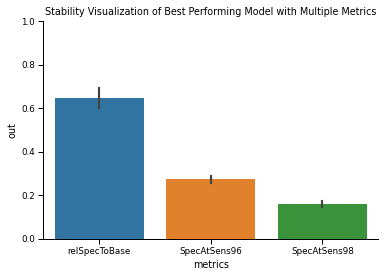

In [13]:
ax = plt.gca()
sns.set_context('paper')
sns.barplot(x='metrics', y='out', data=pd.DataFrame(stab_output_best[['stab_metrics', 'out']].values, columns=['metrics', 'out']), ax=ax)
sns.despine()
ax.set_ylim([0, 1])
ax.set_title("Stability Visualization of Best Performing Model with Multiple Metrics")
plt.savefig(oj(PLOT_PATH, f'best_model_stability_{N_REPS}.png'))

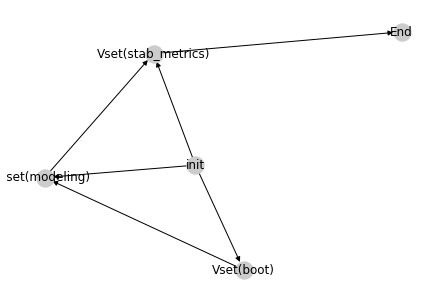

In [9]:
build_graph(stab_metrics)
#plt.savefig(oj(PLOT_PATH, f'best_model_vflow_pipeline.png'))

## Supplementary: Stability comparisons for multiple models

In [ ]:
# initialize data
def stability_pipeline_multiple_models(X_train, X_tune, X_test, y_train, y_tune, y_test):
    X_train, X_test, y_train, y_test = init_args(
        (pd.concat((X_train, X_tune)), X_test, np.concatenate((y_train, y_tune)), y_test),
        names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
    )

    # subsample data
    subsampling_funcs = [
        sklearn.utils.resample for _ in range(10)
    ]
    subsampling_set = Vset(name="subsampling",
                           modules=subsampling_funcs,
                           output_matching=True)
    X_trains, y_trains = subsampling_set(X_train, y_train)

    # fit models
    # TODO: Change the model opetions here to include more models
    dt = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})
    rulefit = imodels.RuleFitClassifier(alpha=20, max_rules=None, random_state=0, tree_size=3, n_estimators=50)
    skope = imodels.SkopeRulesClassifier(precision_min=0.01, recall_min=0.1, n_estimators=10, max_samples=0.8, 
                                         bootstrap=True, max_depth=3, random_state=0)
    boost = imodels.BoostedRulesClassifier(n_estimators=10)
    #saps = imodels.SaplingSumClassifier(max_rules=20)
    weak_learners = [rulefit, skope, boost]
    stbl = stablelinear.StableLinearClassifier(weak_learners=weak_learners, max_complexity=-1, alpha=0.1,
                                               max_rules=None, penalty='l1')

    models = [dt, rulefit, skope, boost, stbl] # boost, saps
    modeling_set = Vset(name="modeling",
                        modules=models,
                        module_keys=["DT", 'rulefit', 'skope', 'boostedrules','stbl']) # , 'boostedrules', 'saps'

    # models = {'DT': DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})}
    # modeling_set = Vset(name="modeling", modules=models)
    modeling_set.fit(X_trains, y_trains)
    pred_proba_test = modeling_set.predict_proba(X_test)

    # get metrics
    relative_metrics_set = Vset(name='relative_metrics',
                              modules=[rel_spec_to_baseline],
                              module_keys=["relSpecToBase"])
    relative_metrics = relative_metrics_set.evaluate(X_test, y_test, pred_proba_test)
    return dict_to_df(relative_metrics)
dset = Dataset()
df_train, df_tune, df_test = dset.get_data()
X_train = drop_df_meta_keys(df_train.drop(columns=[outcome_def]))
y_train = df_train[outcome_def].values
X_tune = drop_df_meta_keys(df_tune.drop(columns=[outcome_def]))
y_tune = df_tune[outcome_def].values
X_test = drop_df_meta_keys(df_test.drop(columns=[outcome_def]))
y_test = df_test[outcome_def].values
processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats
stab_output_multi = stability_pipeline_multiple_models(X_train, X_tune, X_test, y_train, y_tune, y_test)
stab_output_multi['modeling'] = stab_output_multi['modeling'].astype(str)

Text(0.5, 1.0, 'Relative Specificity of Models to Baseline Rule at fixed Sensitivity Level')

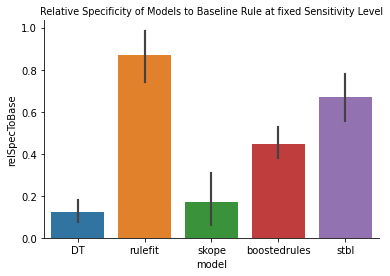

In [17]:
ax = plt.gca()
sns.set_context('paper')
sns.barplot(x='model', y='relSpecToBase', data=pd.DataFrame(stab_output_multi[['modeling', 'out']].values, columns=['model', 'relSpecToBase']), ax=ax)
sns.despine()
ax.set_title("Relative Specificity of Models to Baseline Rule at fixed Sensitivity Level")

## Appendix 2: Problem Solving Documentation
* Rerun code to see if we use the most naive way to use Vflow what output we get
* Determine if vflow package has exact process of using different parameter to split data and visualize output of that method
* Look at if vflow has exact process of `build_Vset` and see how they attempted to visualize the parameter in final output


### Problem Solving Steps
* Rerun code to see if we use the most naive way to use Vflow what output we get
* Determine if vflow package has exact process of using different parameter to split data and visualize output of that method
* Look at if vflow has exact process of `build_Vset` and see how they attempted to visualize the parameter in final output


### Problem set up
* when calling multiple arguments, somehow positions of different args gets mixed up
* solution 1: try to see if a solution is possible with filtering out inconsistent ones

#### Problem report: vflow
* P1: Vset when called on more than two inputs in `*args`, instead of evaluating inputs in paired manner, they are randomly cross-paired, generate N x N outputs rather than N outputs (problem in `convert.py:L309-311 in combine_dicts`)
    * To replicate the problem:
```python
from vflow import init_args, Vset, dict_to_df
import sklearn 
from functools import partial
# Problem: to process function require: Vset(modules=[func])
def vfunc_drop_meta_train_test(dfs):
        df_train, df_tune, df_test = dfs
        X_train = drop_df_meta_keys(df_train.drop(columns=[outcome_def]))
        y_train = df_train[outcome_def].values
        X_tune = drop_df_meta_keys(df_tune.drop(columns=[outcome_def]))
        y_tune = df_tune[outcome_def].values
        X_test = drop_df_meta_keys(df_test.drop(columns=[outcome_def]))
        y_test = df_test[outcome_def].values
        return (pd.concat([X_train, X_tune]), X_test, 
                np.concatenate([y_train, y_tune]), y_test)
drop_meta_train_tests = Vset(name='drop_meta', modules=[vfunc_drop_meta_train_test])
X_trains, X_tests, y_trains, y_tests = drop_meta_train_tests(dfs, n_out=4, 
                                                           keys=['X_trains', 'X_tests', 'y_trains', 'y_tests'])
boot_set = build_vset('boot', sklearn.utils.resample, reps=2, lazy=True)
X_trains, y_trains = boot_set(X_trains, y_trains)
```
```python
In [1]: list(X_trains.keys())[500]
>>> (X_trains,
('include_intervention=False',),
('unclear_feat_default=1', 'only_site_data=1', 'augmented_features=False', 'use_control_type=all'),
('drop_negative_columns=False',),
split_data_0,
drop_meta_0,
y_trains,
data_path,
('include_intervention=True',),
('unclear_feat_default=0', 'only_site_data=1', 'augmented_features=True', 'use_control_type=all'),
('drop_negative_columns=False',),
split_data_0,
('rep=1',))
```

* P2: when using `build_vset(reps=...)` to bootstrap datapoints with `reps=100` we get identical splits for all runs, which is a bit confusing 

### Solutioin 1 brute force split
inelegant and 30% chance doesnt work.

### Solution 2 refer to vflow notebook and learn from example
* Challenge: `build_vset` behavior inconsistent between user installed version and actual version
* Solutions:
    * 2.1: diagnose build_Vset to identify how vfunc
    * 2.2: circumvent this solution and write a cache based Vset function separately.